In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

## 1. Load Dataset and Preprocess the Data

In [2]:
path = "nabirds/"
images = pd.read_csv(path + '/images.txt', sep=" ", header=None, names=['file','path'])
images['cat_num'] = images['path'].str.split('/').str[0]
images.head()

,file,path,cat_num
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,0817
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,0860/0000d9fc4e024c06a0afa55cfb16b12b.jpg,0860
2,00019306-9d83-4334-b255-a447742edce3,0900/000193069d834334b255a447742edce3.jpg,0900
3,0001afd4-99a1-4a67-b940-d419413e23b3,0645/0001afd499a14a67b940d419413e23b3.jpg,0645
4,000332b8-997c-4540-9647-2f0a8495aecf,0929/000332b8997c454096472f0a8495aecf.jpg,0929


In [3]:
data = []

# Open the file and read line by line
with open(path + '/classes.txt', 'r') as file:
    for line in file:
        # Split each line at the first space to separate the category number and the common name
        split_line = line.split(' ', 1)
        if len(split_line) == 2:  # Ensure the line contains both parts
            cat_num = split_line[0].strip()
            common_name = split_line[1].strip()
            data.append([cat_num, common_name])

# Create a DataFrame from the list
classes = pd.DataFrame(data, columns=['cat_num', 'common_name'])
print(classes.head())

  cat_num                common_name
0       0                      Birds
1       1    Ducks, Geese, and Swans
2       2  Grouse, Quail, and Allies
3       3                      Loons
4       4                     Grebes


## 2. Merge

In [4]:
# Ensure both 'cat_num' columns are strings and properly formatted
classes['cat_num'] = classes['cat_num'].apply(lambda x: str(x).zfill(4))
images['cat_num'] = images['cat_num'].apply(lambda x: str(x).zfill(4))

# Now perform the merge
images = pd.merge(images, classes, how='left', on='cat_num')
print(images.head())

                                   file  \
0  0000139e-21dc-4d0c-bfe1-4cae3c85c829   
1  0000d9fc-4e02-4c06-a0af-a55cfb16b12b   
2  00019306-9d83-4334-b255-a447742edce3   
3  0001afd4-99a1-4a67-b940-d419413e23b3   
4  000332b8-997c-4540-9647-2f0a8495aecf   

                                        path cat_num  \
0  0817/0000139e21dc4d0cbfe14cae3c85c829.jpg    0817   
1  0860/0000d9fc4e024c06a0afa55cfb16b12b.jpg    0860   
2  0900/000193069d834334b255a447742edce3.jpg    0900   
3  0645/0001afd499a14a67b940d419413e23b3.jpg    0645   
4  0929/000332b8997c454096472f0a8495aecf.jpg    0929   

                          common_name  
0                        Oak Titmouse  
1                            Ovenbird  
2                    Savannah Sparrow  
3  Eared Grebe (Nonbreeding/juvenile)  
4                      Eastern Phoebe  


In [5]:
print(classes.head())

  cat_num                common_name
0    0000                      Birds
1    0001    Ducks, Geese, and Swans
2    0002  Grouse, Quail, and Allies
3    0003                      Loons
4    0004                     Grebes


## 3. Check datatypes and test the preprocessed data

In [6]:
# Check data types and unique values
print(classes.dtypes)
print(images.dtypes)
print(classes['cat_num'].unique())  # Check for unexpected characters or formatting

cat_num        object
common_name    object
dtype: object
file           object
path           object
cat_num        object
common_name    object
dtype: object
['0000' '0001' '0002' ... '1008' '1009' '1010']


In [7]:
print("Number of classes in the dataset:", classes['cat_num'].nunique())
print("Number of images in the dataset:", images.shape[0])

Number of classes in the dataset: 1011
Number of images in the dataset: 48562


## 4. Train_test_split.txt in the  dataset merge with images

In [8]:
#import train_test_split and merge with images to get the train_test split provided with dataset
split = pd.read_csv(path + '/train_test_split.txt', sep=" ", header=None, names=['file','train_test'])
images = pd.merge(images, split,  how='left', on='file')
images.head()

,file,path,cat_num,common_name,train_test
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,0817,Oak Titmouse,0
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,0860/0000d9fc4e024c06a0afa55cfb16b12b.jpg,0860,Ovenbird,0
2,00019306-9d83-4334-b255-a447742edce3,0900/000193069d834334b255a447742edce3.jpg,0900,Savannah Sparrow,0
3,0001afd4-99a1-4a67-b940-d419413e23b3,0645/0001afd499a14a67b940d419413e23b3.jpg,0645,Eared Grebe (Nonbreeding/juvenile),1
4,000332b8-997c-4540-9647-2f0a8495aecf,0929/000332b8997c454096472f0a8495aecf.jpg,0929,Eastern Phoebe,0


## 5. Exploratory Data Analysis

In [9]:
print("Number of images:", images.shape[0])
print("Number of unique bird classes:", images['common_name'].nunique())

print("Missing values in images dataframe:")
print(images.isnull().sum())

Number of images: 48562
Number of unique bird classes: 555
Missing values in images dataframe:
file           0
path           0
cat_num        0
common_name    0
train_test     0
dtype: int64


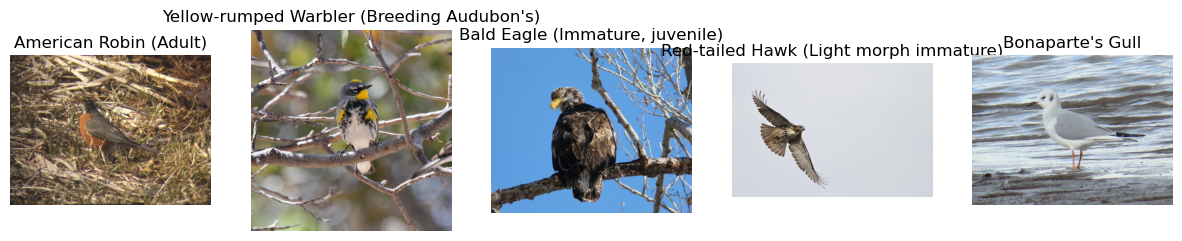

In [10]:
num_display_images = 5
sampled_image_data = images.sample(n=num_display_images)
fig, image_axes = plt.subplots(1, num_display_images, figsize=(15, 5))

for ax, (_, image_row) in zip(image_axes, sampled_image_data.iterrows()):
    full_image_path = "nabirds/images/" + image_row['path']
    try:
        bird_image = Image.open(full_image_path)
        ax.imshow(bird_image)
        ax.axis('off')
        ax.set_title(image_row['common_name'])
    except FileNotFoundError:
        ax.set_title("File not found")
        print(f"File not found: {full_image_path}")
plt.show()

In [11]:
class_distribution = images['common_name'].value_counts()
print(class_distribution)

Barred Owl                                  120
Lesser Yellowlegs                           120
Red-breasted Nuthatch                       120
Black-and-white Warbler                     120
Forster's Tern                              120
                                           ... 
Fox Sparrow (Thick-billed/Slate-colored)     25
Snow Bunting (Breeding adult)                24
Red-throated Loon (Breeding)                 23
Purple Gallinule (Immature)                  21
Dark-eyed Junco (White-winged)               13
Name: common_name, Length: 555, dtype: int64


In [12]:
sampled_class_distribution = class_distribution.sample(n=30, random_state=1)
sorted_sample = sampled_class_distribution.sort_values(ascending=True)

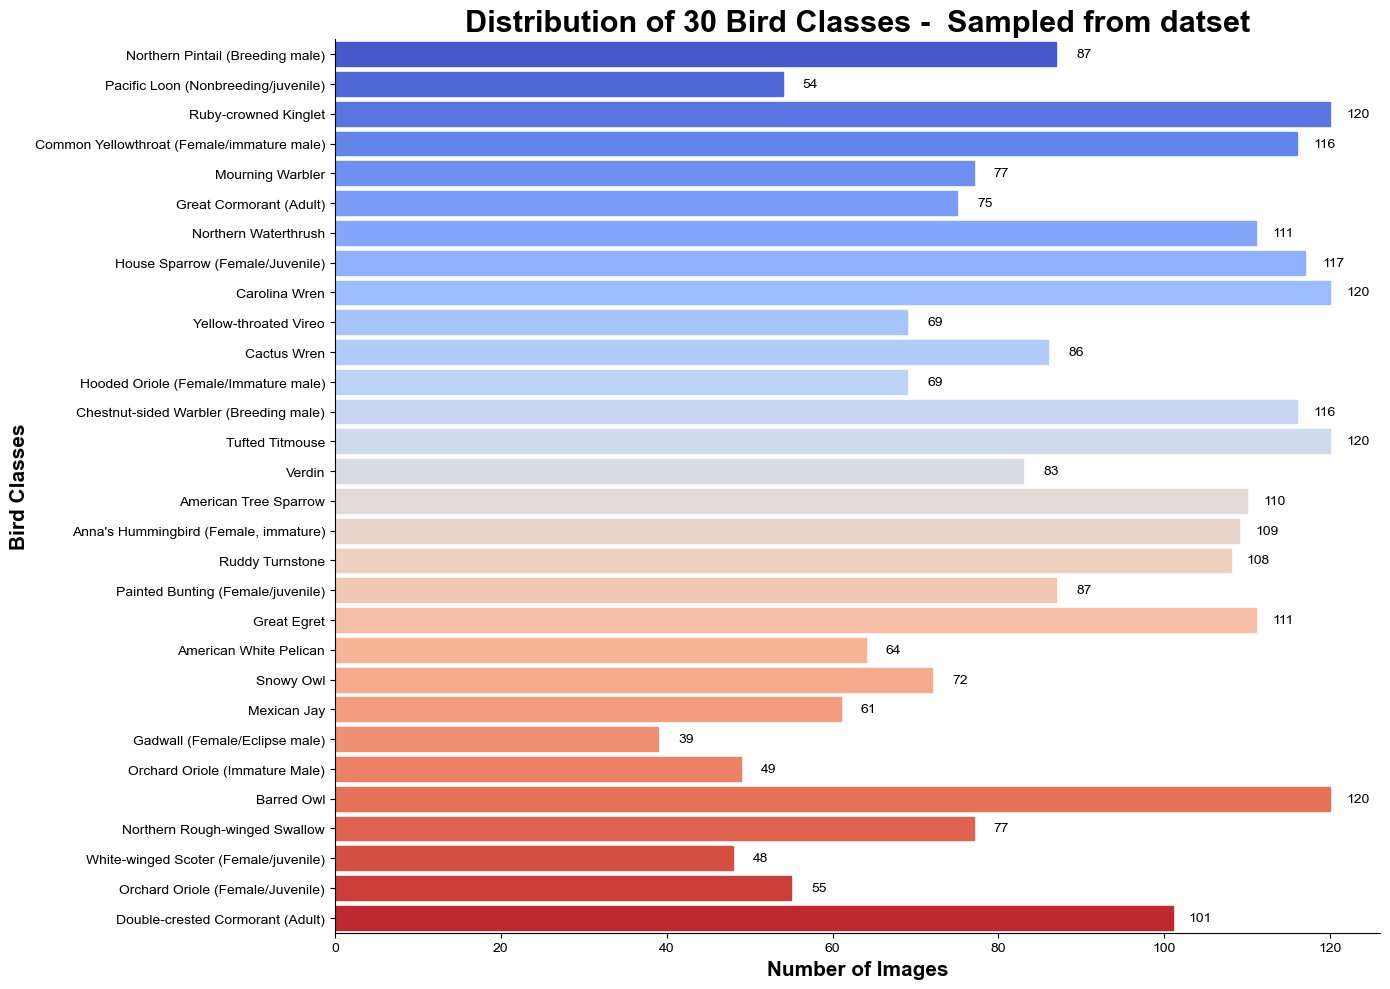

In [13]:
num_classes = sampled_class_distribution.size
cmap = sns.color_palette("coolwarm", n_colors=num_classes)

plt.figure(figsize=(14, 10))
bar_plot = sns.barplot(x=sampled_class_distribution.values, y=sampled_class_distribution.index)
for i, bar in enumerate(bar_plot.patches):
    bar.set_color(cmap[i])

for bar in bar_plot.patches:
    bar_plot.annotate(format(bar.get_width(), '.0f'),
                      (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                      ha='center', va='center',
                      xytext=(20, 0),
                      textcoords='offset points')

plt.title('Distribution of 30 Bird Classes -  Sampled from datset', fontsize=22, fontweight='bold')
plt.xlabel('Number of Images', fontsize=15, fontweight='bold')
plt.ylabel('Bird Classes', fontsize=15, fontweight='bold')
sns.set_style("white", {'axes.facecolor': 'whitesmoke', 'grid.color': '.9'})
sns.despine()
plt.tight_layout()
plt.show()

In [14]:
images_base_path = "nabirds/images/"

In [15]:
def analyze_image_sizes(data):
    widths, heights = [], []
    for _, row in data.iterrows():
        image_path = images_base_path + row['path']
        with Image.open(image_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

    return widths, heights

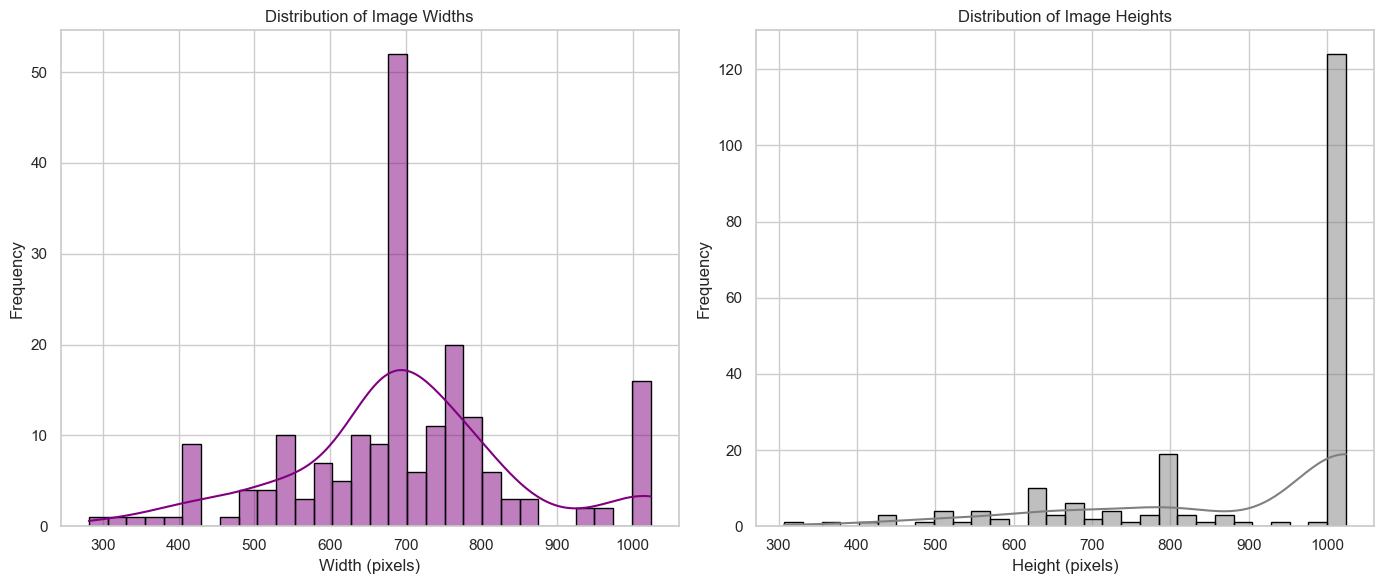

In [16]:
heights, widths = analyze_image_sizes(images.sample(200))
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=30, kde=True, color='purple', edgecolor='black')
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.histplot(heights, bins=30, kde=True, color='gray', edgecolor='black')
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 6. ResNet 50 - Image classification

##### This architecture can be used on computer vision tasks such as image classification, object localisation, object detection.

![Example Image](https://iq.opengenus.org/content/images/2020/03/Screenshot-from-2020-03-20-15-49-54.png "RESNET50 Architecture")

* A convoultion with a kernel size of 7 * 7 and 64 different kernels all with a stride of size 2 giving us 1 layer.
* Next we see max pooling with also a stride size of 2.
* In the next convolution there is a 1 * 1,64 kernel following this a 3 * 3,64 kernel and at last a 1 * 1,256 kernel, These three layers are repeated in total 3 time so giving us 9 layers in this step.
* Next we see kernel of 1 * 1,128 after that a kernel of 3 * 3,128 and at last a kernel of 1 * 1,512 this step was repeated 4 time so giving us 12 layers in this step.
* After that there is a kernal of 1 * 1,256 and two more kernels with 3 * 3,256 and 1 * 1,1024 and this is repeated 6 time giving us a total of 18 layers.
* And then again a 1 * 1,512 kernel with two more of 3 * 3,512 and 1 * 1,2048 and this was repeated 3 times giving us a total of 9 layers.
* After that we do a average pool and end it with a fully connected layer containing 1000 nodes and at the end a softmax function so this gives us 1 layer.
We don't actually count the activation functions and the max/ average pooling layers.

So totaling this it gives us a 1 + 9 + 12 + 18 + 9 + 1 = 50 layers Deep Convolutional network.

### a) Training the model on NA Birds dataset

In [17]:
path = "nabirds/images/"

In [18]:

train_df, val_df = train_test_split(images, test_size=0.2, random_state=42, stratify=images['common_name'])

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col='path',
    y_col='common_name',
    target_size=(384, 384),
    batch_size=24,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=path,
    x_col='path',
    y_col='common_name',
    target_size=(384, 384),
    batch_size=24,
    class_mode='categorical'
)

#load ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 384, 3))

#freeze the layers except the last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

#add custom layers with L2 regularization and dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(len(train_generator.class_indices), activation='softmax', kernel_regularizer=l2(0.01))(x)

#create the model
model = Model(inputs=base_model.input, outputs=output)

#compile the model
optimizer_adam = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])

#callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_lr=0.00001)

#train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)


model.save('resnet50_nabirds_model.h5') #save the model

val_scores = model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size) #evaluate
print(f"Validation Set - Loss: {val_scores[0]}, Accuracy: {val_scores[1]}")

Found 38849 validated image filenames belonging to 555 classes.
Found 9713 validated image filenames belonging to 555 classes.
Epoch 1/15


/Users/shreshtagundoju/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 8186s 5s/step - accuracy: 0.0808 - loss: 17.5548 - val_accuracy: 0.4196 - val_loss: 6.3055 - learning_rate: 1.0000e-04
Epoch 2/15
   1/1618 ━━━━━━━━━━━━━━━━━━━━ 2:00:11 4s/step - accuracy: 0.2083 - loss: 7.1325

2024-05-17 10:29:41.715109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/shreshtagundoju/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2083 - loss: 7.1325 - val_accuracy: 0.3529 - val_loss: 6.5831 - learning_rate: 1.0000e-04
Epoch 3/15


2024-05-17 10:29:43.993985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 8524s 5s/step - accuracy: 0.3507 - loss: 5.9172 - val_accuracy: 0.5555 - val_loss: 3.8852 - learning_rate: 1.0000e-04
Epoch 4/15
   1/1618 ━━━━━━━━━━━━━━━━━━━━ 1:44:08 4s/step - accuracy: 0.4583 - loss: 4.1355

2024-05-17 12:51:51.960722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.4583 - loss: 4.1355 - val_accuracy: 0.3529 - val_loss: 4.1848 - learning_rate: 1.0000e-04
Epoch 5/15


2024-05-17 12:51:53.997876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 7215s 4s/step - accuracy: 0.4790 - loss: 3.9771 - val_accuracy: 0.5976 - val_loss: 3.1510 - learning_rate: 1.0000e-04
Epoch 6/15
   1/1618 ━━━━━━━━━━━━━━━━━━━━ 1:37:20 4s/step - accuracy: 0.5417 - loss: 3.6595

2024-05-17 14:52:12.997677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.5417 - loss: 3.6595 - val_accuracy: 0.6471 - val_loss: 3.0684 - learning_rate: 1.0000e-04
Epoch 7/15


2024-05-17 14:52:14.916957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 6909s 4s/step - accuracy: 0.5633 - loss: 3.1931 - val_accuracy: 0.6307 - val_loss: 2.7245 - learning_rate: 1.0000e-04
Epoch 8/15
   1/1618 ━━━━━━━━━━━━━━━━━━━━ 1:36:03 4s/step - accuracy: 0.7083 - loss: 2.9111

2024-05-17 16:47:27.747876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7083 - loss: 2.9111 - val_accuracy: 0.7059 - val_loss: 2.5415 - learning_rate: 1.0000e-04
Epoch 9/15


2024-05-17 16:47:29.601179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 7269s 4s/step - accuracy: 0.6159 - loss: 2.7788 - val_accuracy: 0.6576 - val_loss: 2.4823 - learning_rate: 1.0000e-04
Epoch 10/15
   1/1618 ━━━━━━━━━━━━━━━━━━━━ 1:40:07 4s/step - accuracy: 0.4167 - loss: 3.1855

2024-05-17 18:48:42.623767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.4167 - loss: 3.1855 - val_accuracy: 0.8235 - val_loss: 2.0141 - learning_rate: 1.0000e-04
Epoch 11/15


2024-05-17 18:48:44.672773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 8326s 5s/step - accuracy: 0.6619 - loss: 2.4755 - val_accuracy: 0.6788 - val_loss: 2.3099 - learning_rate: 1.0000e-04
Epoch 12/15
   1/1618 ━━━━━━━━━━━━━━━━━━━━ 1:51:41 4s/step - accuracy: 0.6250 - loss: 2.5604

2024-05-17 21:07:34.726079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 12: ReduceLROnPlateau reducing learning rate to 1e-05.


2024-05-17 21:07:36.871616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6250 - loss: 2.5604 - val_accuracy: 0.6471 - val_loss: 2.3091 - learning_rate: 1.0000e-04
Epoch 13/15
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 10076s 6s/step - accuracy: 0.7511 - loss: 2.0915 - val_accuracy: 0.7496 - val_loss: 2.0419 - learning_rate: 1.0000e-05
Epoch 13: early stopping


404/404 ━━━━━━━━━━━━━━━━━━━━ 1114s 3s/step - accuracy: 0.7508 - loss: 2.0480
Validation Set - Loss: 2.042473316192627, Accuracy: 0.7494843006134033


In [23]:
model.save('best_model.keras')

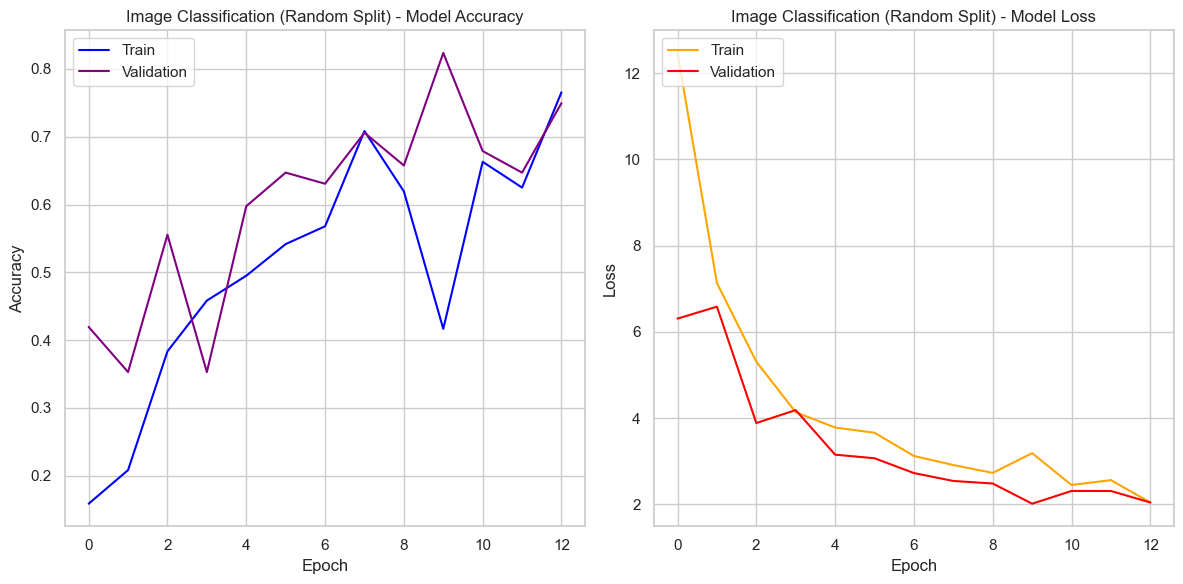

In [21]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='blue', label='Train')
plt.plot(history.history['val_accuracy'], color='purple', label='Validation')
plt.title('Image Classification (Random Split) - Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='orange', label='Train')
plt.plot(history.history['val_loss'], color='red', label='Validation')
plt.title('Image Classification (Random Split) - Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()